# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_1m_2f_240213_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [50, 1860]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 69319
Frames resolution: 1080 x 1920


In [7]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [8]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,452.568390,23.455796,452.688289,23.438149,0.0,442.000000,0.000000,0.541176,444.000000,2.000000,-1.239867,2398.0,114.920125,43.254637,0.926462,6
1,1,0,1395.714555,74.415535,1394.490291,76.110912,0.0,1361.000000,31.000000,0.541176,1431.000000,63.000000,1.444069,13260.0,258.805432,90.401761,0.937009,6
2,2,0,936.520344,150.086347,938.328113,150.661421,0.0,883.000000,82.000000,0.596078,867.000000,84.000000,1.091933,15484.0,233.558569,101.816993,0.899977,6
3,3,0,1251.335731,953.094922,1250.768461,953.328558,NaN,1251.335731,953.094922,NaN,1251.335731,953.094922,-1.463223,16403.0,291.441219,105.274607,0.932480,6
4,4,0,1773.502466,1058.932603,1773.374596,1058.941790,NaN,1773.502466,1058.932603,NaN,1773.502466,1058.932603,1.507145,1825.0,114.689462,34.952574,0.952430,6
5,5,0,1610.748264,1061.875000,1610.130767,1061.839379,0.0,1553.000000,1055.000000,0.517647,1553.000000,1056.000000,1.478707,576.0,112.968434,18.166119,0.986986,6


In [9]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[1]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         6   452.568390    23.455796    -1.239867
1   1     0         6  1395.714555    74.415535     1.444069
2   2     0         6   936.520344   150.086347     1.091933
3   3     0         6  1251.335731   953.094922    -1.463223
4   4     0         6  1773.502466  1058.932603     1.507145
5   5     0         6  1610.748264  1061.875000     1.478707


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,1395.714555,74.415535,1394.490291,76.110912,0.0,1361.000000,31.000000,0.541176,1431.000000,63.000000,1.444069,13260.0,258.805432,90.401761,0.937009,6
2,1,0,936.520344,150.086347,938.328113,150.661421,0.0,883.000000,82.000000,0.596078,867.000000,84.000000,1.091933,15484.0,233.558569,101.816993,0.899977,6
3,2,0,1251.335731,953.094922,1250.768461,953.328558,NaN,1251.335731,953.094922,NaN,1251.335731,953.094922,-1.091933,16403.0,291.441219,105.274607,0.932480,6
6,0,3,452.101220,23.738211,452.221731,23.726892,0.0,442.000000,0.000000,0.541176,444.000000,2.000000,-1.250303,2460.0,115.953353,43.571062,0.926716,6
7,1,3,74.155632,38.855237,74.445078,38.892861,NaN,74.155632,38.855237,NaN,74.155632,38.855237,1.428480,2024.0,145.128185,30.231193,0.978064,6
8,2,3,1395.656076,74.537838,1394.472187,76.286303,0.0,1360.000000,31.000000,0.541176,1413.000000,63.000000,1.443184,13439.0,258.831131,90.376534,0.937059,6
9,3,3,936.681533,150.166346,938.579758,150.730723,0.0,883.000000,82.000000,0.600000,886.000000,88.000000,1.091387,15606.0,233.428291,102.098531,0.899273,6


In [10]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
14895,1,69318,1612.478977,946.003725,1608.255699,948.735563,NaN,1612.478977,946.003725,NaN,1612.478977,946.003725,-0.998603,15840.0,280.488329,111.539394,0.917532,6
14896,2,69318,126.993954,960.946133,136.241055,964.290272,NaN,126.993954,960.946133,NaN,126.993954,960.946133,1.147710,12735.0,246.692665,93.764560,0.924951,6
14897,3,69318,977.190403,953.878871,975.037313,953.066516,0.0,975.000000,900.000000,0.686275,902.000000,981.000000,-1.473328,17568.0,270.879340,91.356450,0.941412,6
14898,4,69318,482.974675,1058.663244,484.139435,1059.314446,0.0,461.000000,1036.000000,0.545098,464.000000,1051.000000,1.177548,1461.0,99.646506,27.767620,0.960389,6
14899,5,69318,1245.404422,1066.024413,1245.039604,1066.022452,0.0,1277.000000,1056.000000,0.686275,1196.000000,1061.000000,1.529699,2171.0,160.149835,23.326928,0.989335,6


## Velocities distribution in each frame

In [11]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


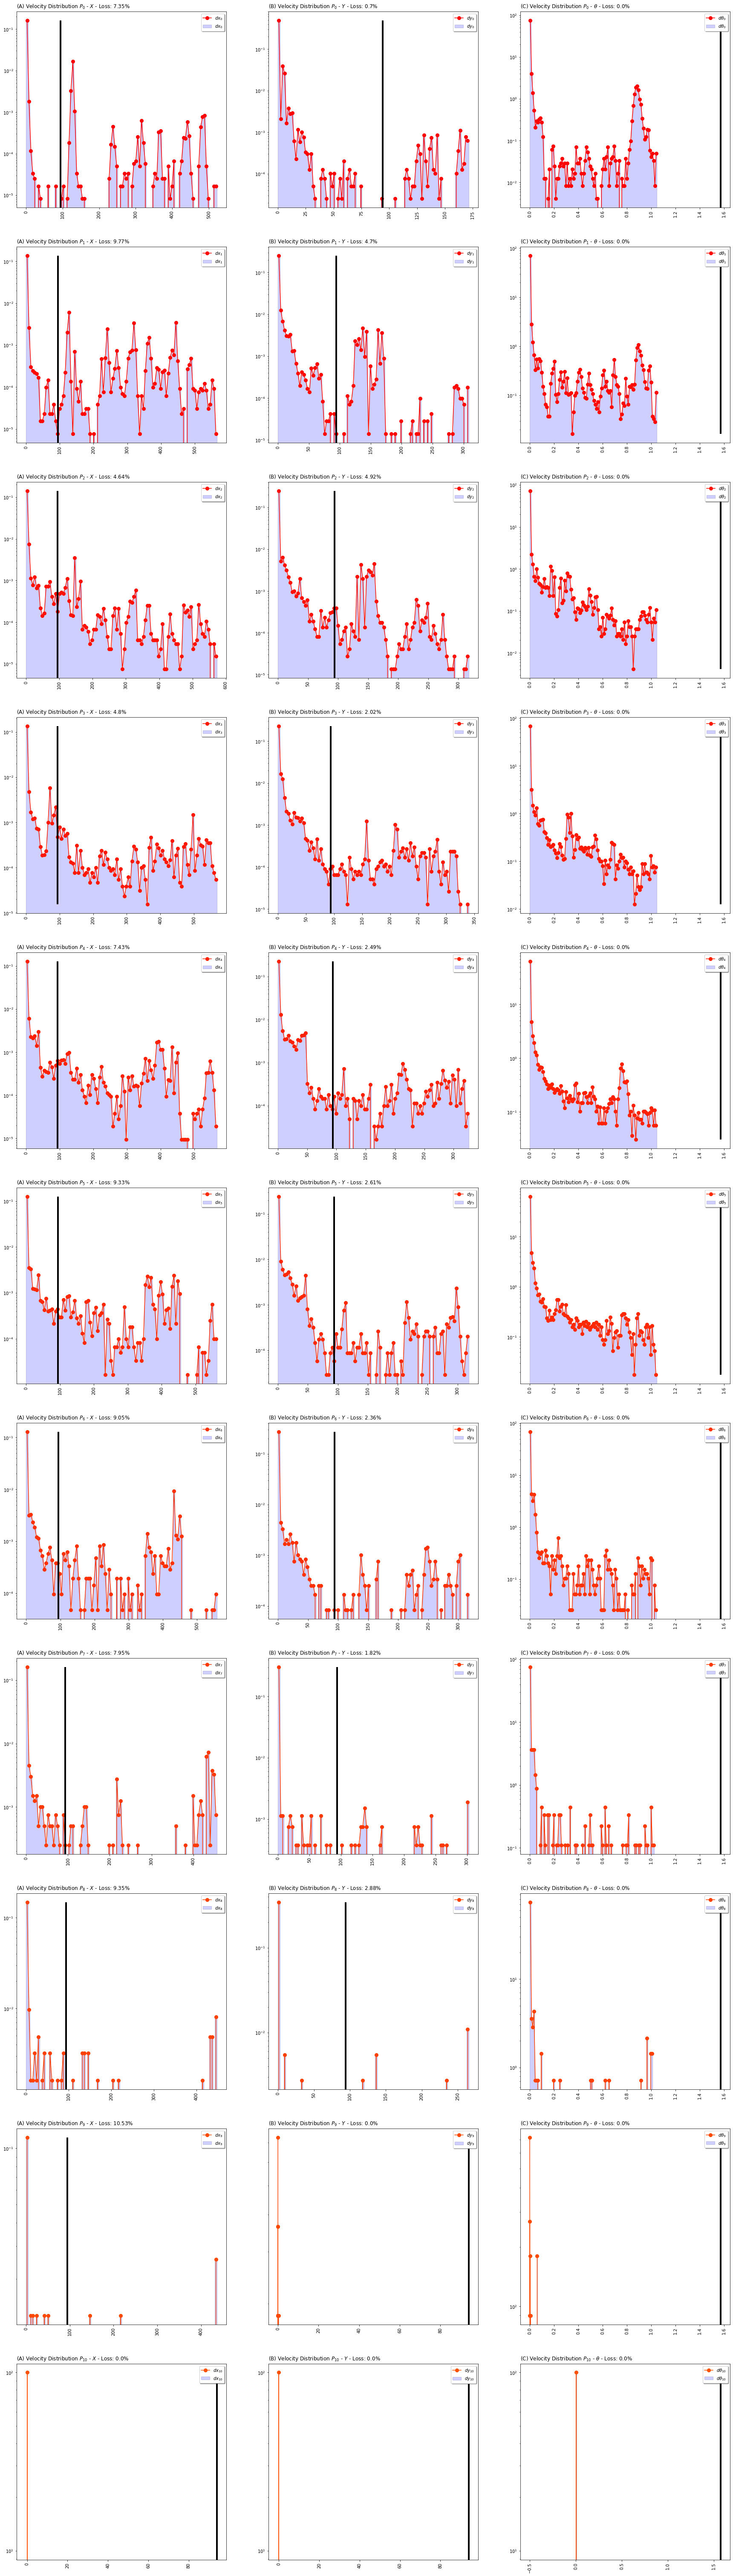

In [12]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [13]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,3,1455
1,4,15836
2,5,39350
3,6,42339
4,7,19992
5,8,5928
6,9,1080
7,10,170
8,11,22


## Clustering frames

In [14]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 50.121723080008245 



In [15]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [16]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.963764
1,3,False,True,False,0.041214
2,3,True,False,False,0.046762
3,3,True,True,False,0.101449
4,4,False,False,False,11.132422
5,4,False,True,False,0.306724
6,4,True,False,False,0.524681
7,4,True,True,False,0.587294
8,5,False,False,False,28.586374
9,5,False,True,False,0.514377


In [17]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 18.11189310239075 
	- Angle: 50.121723080008245 



In [18]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0%
Final loss data X-axis: 0.32893313135684915%
Final loss data Y-axis: 0.29286590204140517%
Final loss data Angle : 0.09954555291062542%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.014427
1,3,False,False,True,0.200534
2,3,False,True,False,0.007213
3,3,False,True,True,0.106759
4,3,True,False,True,0.077905
5,3,True,True,False,0.077905
6,3,True,True,True,99.515256


In [19]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 18.11189310239075 
	- Angle: 50.121723080008245 



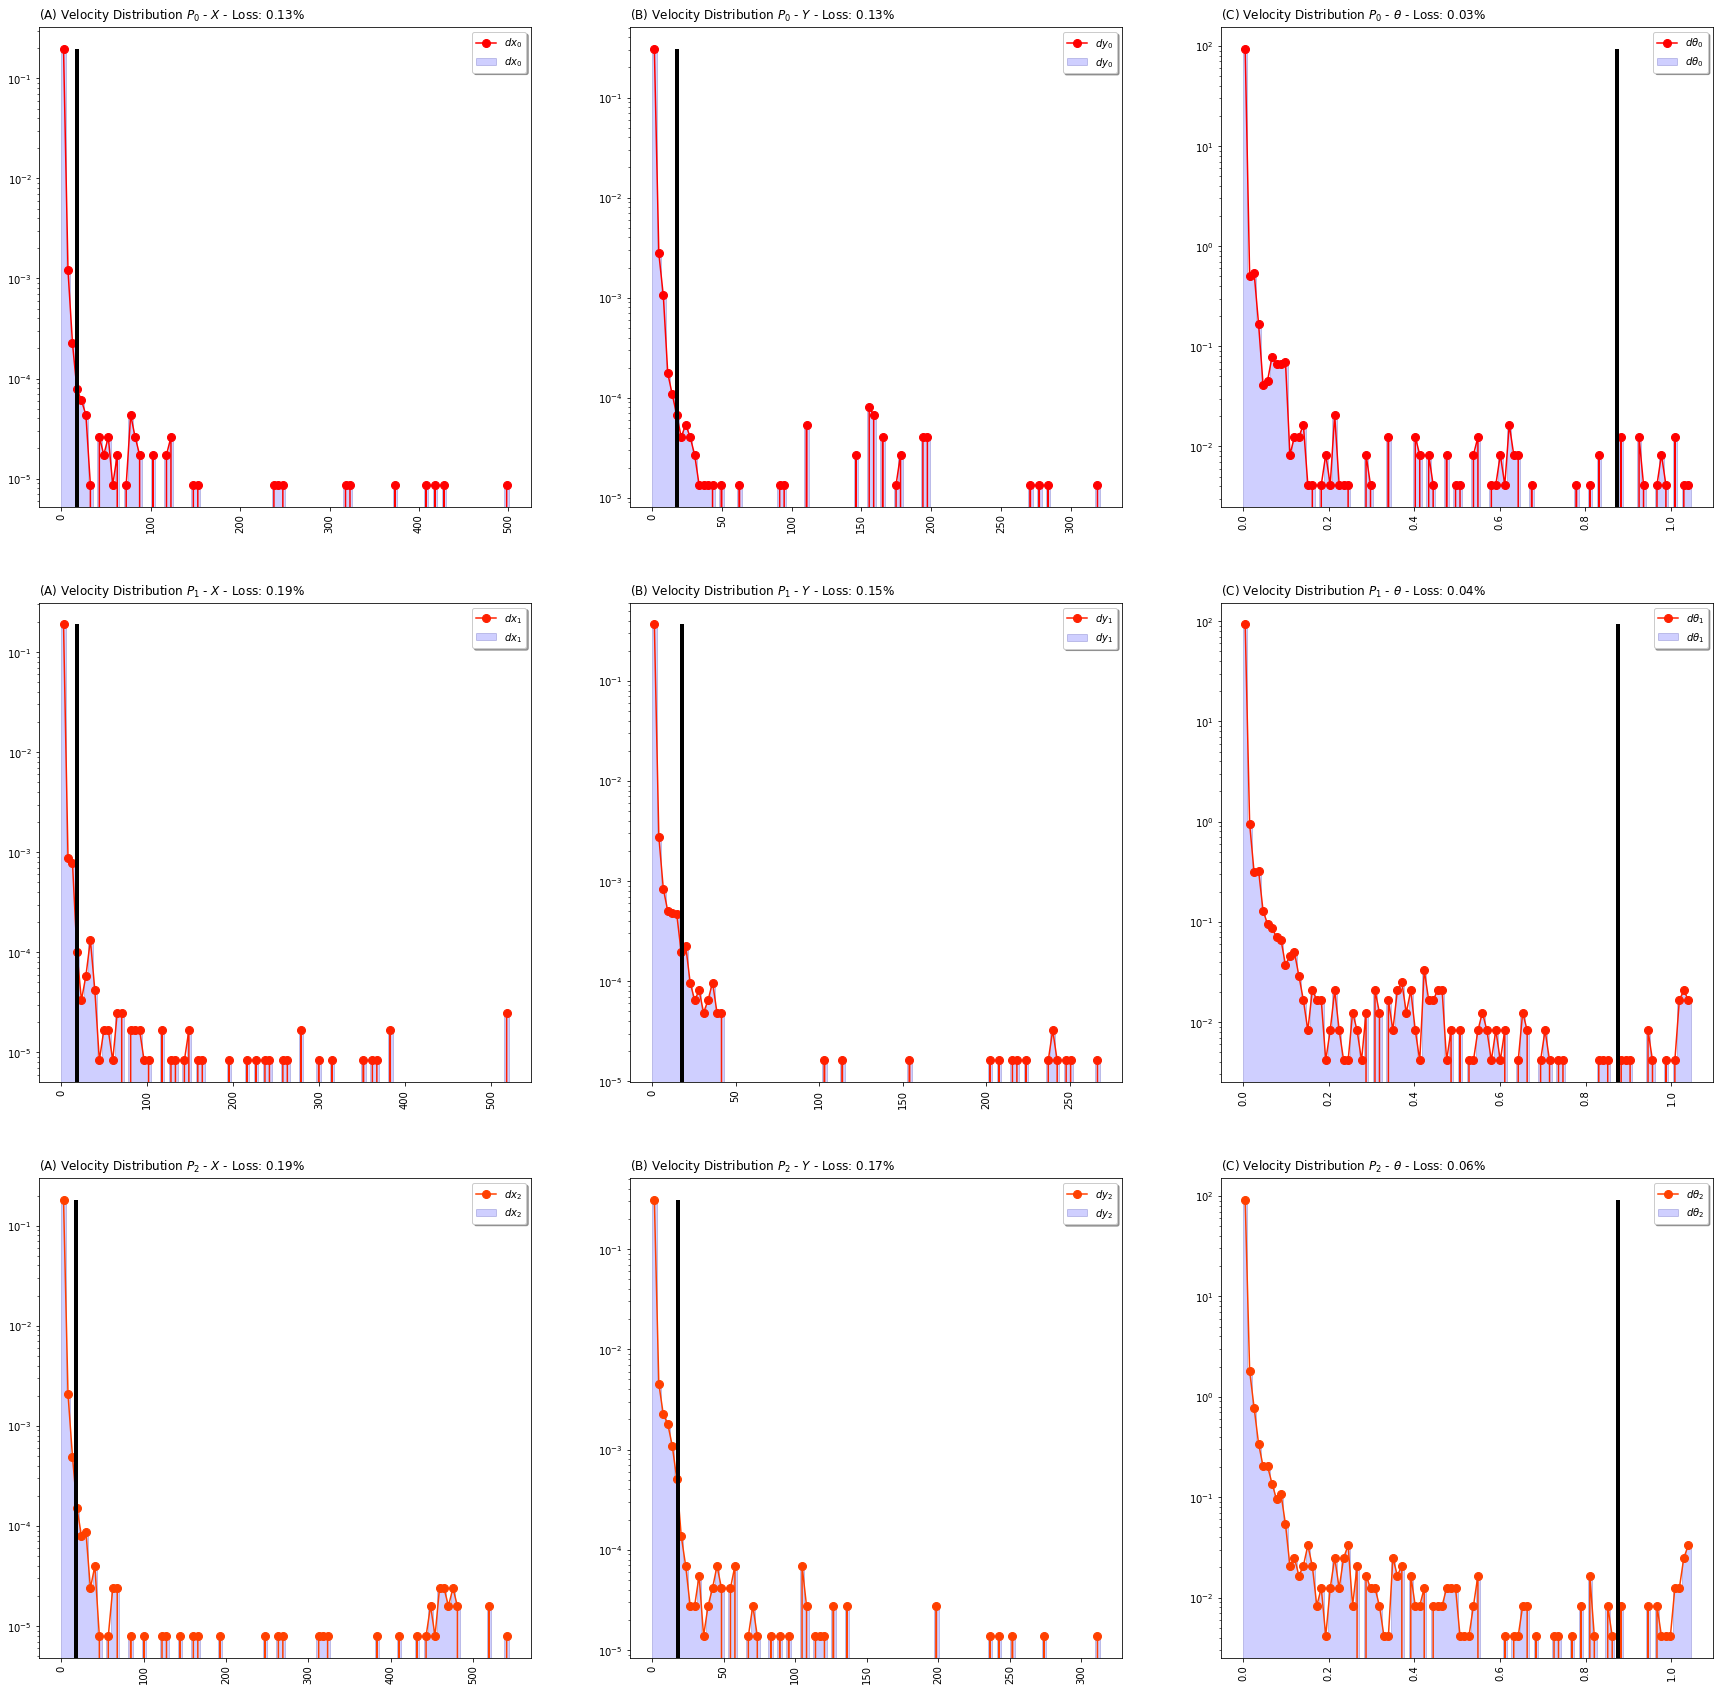

In [20]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [21]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [22]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1395.714555,74.415535,1394.490291,76.110912,0.0,1361.000000,31.000000,0.541176,1431.000000,63.000000,1.444069,13260.0,258.805432,90.401761,0.937009,3,NaN,NaN,NaN,NaN,False,False,False
484,1,0,936.520344,150.086347,938.328113,150.661421,0.0,883.000000,82.000000,0.596078,867.000000,84.000000,1.091933,15484.0,233.558569,101.816993,0.899977,3,NaN,NaN,NaN,NaN,False,False,False
968,2,0,1251.335731,953.094922,1250.768461,953.328558,NaN,1251.335731,953.094922,NaN,1251.335731,953.094922,-1.091933,16403.0,291.441219,105.274607,0.932480,3,NaN,NaN,NaN,NaN,False,False,False
1452,0,3,1395.656076,74.537838,1394.472187,76.286303,0.0,1360.000000,31.000000,0.541176,1413.000000,63.000000,1.443184,13439.0,258.831131,90.376534,0.937059,3,3.0,-0.019493,0.040767,-0.000295,False,False,False
1453,1,3,936.681533,150.166346,938.579758,150.730723,0.0,883.000000,82.000000,0.600000,886.000000,88.000000,1.091387,15606.0,233.428291,102.098531,0.899273,3,3.0,0.053730,0.026666,-0.000182,False,False,False
1454,2,3,1259.734230,945.028132,1260.310406,945.472877,0.0,1269.000000,888.000000,0.588235,1363.000000,911.000000,-1.545628,16138.0,293.031723,108.012501,0.929587,3,3.0,2.799499,-2.688930,-0.151232,False,False,False
1455,0,6,1395.666146,74.585565,1394.489867,76.351090,0.0,1360.000000,31.000000,0.541176,1421.000000,63.000000,1.443277,13440.0,258.874172,90.337592,0.937136,3,3.0,0.003357,0.015909,0.000031,False,False,False
1456,1,6,936.829250,150.266330,938.833805,150.875648,0.0,883.000000,82.000000,0.600000,886.000000,88.000000,1.091475,15631.0,234.114523,102.033044,0.900031,3,3.0,0.049239,0.033328,0.000029,False,False,False
1457,2,6,1278.831629,941.567803,1280.489933,942.532419,NaN,1278.831629,941.567803,NaN,1278.831629,941.567803,1.549953,15840.0,297.859577,106.652265,0.933698,3,3.0,6.365800,-1.153443,1.031860,False,False,True


## Visualize final data

In [23]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


In [24]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_1m_2f_240213_1_c.zip'